<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/advanced_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning for Computer Vision
In this notebook we deal with two fundamental tasks in computer vision beyond image classification:

* semantic segmentation
* object detection

In semantic segmentation each pixel of an image is assigned a class so that each pixel is part of a group and the image is separated in clusters of pixels. The semantic segmentation assigns the same value to all the pixels of a certain class even if they belong to different objects of the same type. In instance segmentation the algorithm is able to classify a pixel and also tell which cluster it belongs to. An object detection algorithm is able to detect the location of the object in the image by adding a bounding box around it with a label for its class.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import time

## Semantic segmentation
We will use the [Oxford-IIIT Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. it contains 7390 RGB images with 8 bit depth so that the pixel value ranges between 0 and 255. Each image has a corresponding target raster image of the same size of the input image where each pixel can take one of three values

* 1 (foreground)
* 2 (background)
* 3 (contour)

We download and untar the input images and the annotated raster files.  

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-07-16 08:45:33--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-07-16 08:45:33--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-07-16 08:45:34--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [3]:
from PIL import Image
img = Image.open('/content/images/Abyssinian_1.jpg')
img.size

(600, 400)

In [4]:
annotation = Image.open('/content/annotations/trimaps/Abyssinian_1.png')
annotation.size

(600, 400)

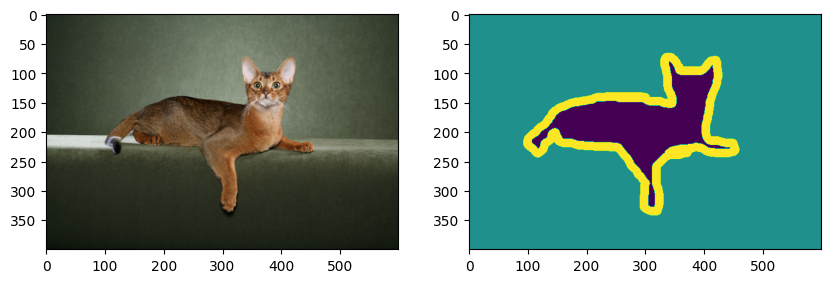

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(annotation)

In [6]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted([os.path.join(input_dir, fname)
for fname in os.listdir(input_dir)
if fname.endswith(".jpg")])

In [7]:
target_paths = sorted([os.path.join(target_dir, fname)
for fname in os.listdir(target_dir)
if fname.endswith(".png") and not fname.startswith(".")])

We resize and shuffle the images then we load the images into NumPy arrays and split the arrays into a training set and a validation set

In [8]:
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [9]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [10]:
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

We load the images into arrays of float32 and the target files into arrays of 8 bit integers

In [11]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

Now we load the arrays into a training and a validation set

In [12]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

We define the model

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

The first part of the model, let's call it the encoder, uses convolutional layers in a way similar to that we used for image classification: we reduce the size of the feature maps and increase their number from the 3 RGB channels to 256 filters. The reduction of the height and width is done using a stride 2 instead of a MaxPooling layer. This technique preserves a feature's location since it is relevant for a segmentation task. The second part of the model, let's call it the decoder, uses a different type of convolutional layer called transpose and the number of feature maps decreases while their size increases till becoming of the same size of the input. The purpose of the decoder part is to learn how to upsample the feature maps so that it can apply the information learnt from the encoder to each pixel in the input image.

![segmentation architecture](https://github.com/luigiselmi/dl_tensorflow/blob/main/images/segmentation_architecture.jpg?raw=1)

In [ ]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

We compile the model and define the callbacks to be used for the training

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
    save_best_only=True)
]

In [ ]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 104s 792ms/step - loss: 0.9413 - val_loss: 0.8876
Epoch 2/50
100/100 [==============================] - 57s 573ms/step - loss: 0.8831 - val_loss: 0.8535
Epoch 3/50
100/100 [==============================] - 58s 580ms/step - loss: 0.8386 - val_loss: 0.8197
Epoch 4/50
100/100 [==============================] - 59s 587ms/step - loss: 0.8151 - val_loss: 0.8131
Epoch 5/50
100/100 [==============================] - 59s 592ms/step - loss: 0.7942 - val_loss: 0.7623
Epoch 6/50
100/100 [==============================] - 59s 594ms/step - loss: 0.7804 - val_loss: 0.7342
Epoch 7/50
100/100 [==============================] - 59s 590ms/step - loss: 0.7464 - val_loss: 0.7664
Epoch 8/50
100/100 [==============================] - 59s 595ms/step - loss: 0.7339 - val_loss: 0.7002
Epoch 9/50
100/100 [==============================] - 59s 595ms/step - loss: 0.7145 - val_loss: 0.7315
Epoch 10/50
100/100 [==============================] - 60s 596ms/step - 

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

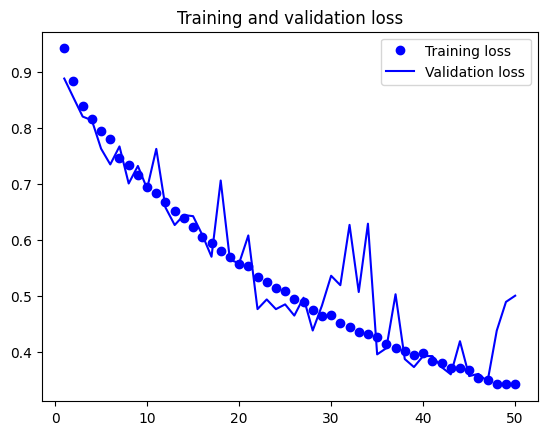

In [ ]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

We assess the model performance on some images to see whether the segmantation mask resemble the shape of the cat or dog in the input image

1/1 [==============================] - 0s 180ms/step


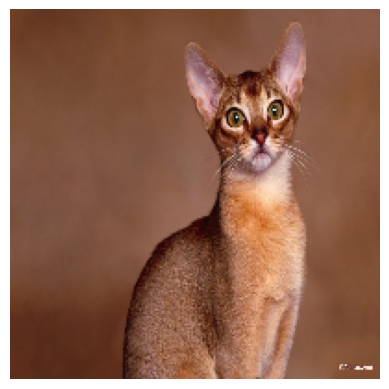

In [ ]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

In [ ]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

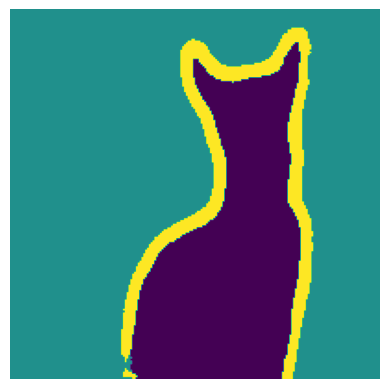

In [ ]:
display_mask(mask)